# Smile Classification using CNN on the CelebA Dataset
This project focuses on building a Convolutional Neural Network (CNN) to classify smiles in facial images using the CelebA dataset, a well-known large-scale dataset containing celebrity images with various attributes. The primary goal is to train a deep learning model that can accurately distinguish between smiling and non-smiling faces. By leveraging data augmentation techniques, a carefully designed CNN architecture, and optimized training processes, this project aims to create an effective smile classification system. The insights gained from this project can be applied to facial recognition, emotion detection, and other computer vision tasks in real-world applications.

## Data Preparation

In [1]:
import pandas as pd
import torch
import os
from PIL import Image
from torch import device
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
img_dir = 'archive/img_align_celeba/img_align_celeba'
partition_file = 'archive/list_eval_partition.csv'
attributes_file = 'archive/list_attr_celeba.csv'

partition_df = pd.read_csv(partition_file)
attributes_df = pd.read_csv(attributes_file)

# Merge partition and attributes datasets
merged_df = pd.merge(partition_df, attributes_df,on='image_id')

# Map partition values to names
partition_map = {0: 'train', 1: 'valid', 2: 'test'}
merged_df['partition'] = merged_df['partition'].map(partition_map)

merged_df.sample(5)

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
114328,114329.jpg,train,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
162961,162962.jpg,valid,1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,1
129590,129591.jpg,train,-1,1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
128752,128753.jpg,train,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,-1,-1,1
69781,069782.jpg,train,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1


In [3]:
# We only want to classify the smile
merged_df = merged_df[['image_id', 'partition', 'Smiling']]
merged_df.loc[merged_df['Smiling']==-1, 'Smiling'] = 0

merged_df.head(5)

,image_id,partition,Smiling
0,000001.jpg,train,1
1,000002.jpg,train,1
2,000003.jpg,train,0
3,000004.jpg,train,0
4,000005.jpg,train,0


The transformations for the training dataset augment the dataset by adding variability (through random cropping and flipping) and resize images to a consistent size. This helps prevent overfitting, improves the model’s ability to handle different orientations and perspectives, and ensures consistent input dimensions, making the training process more robust and efficient.

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

Let's see how the transformations work on some sample images:

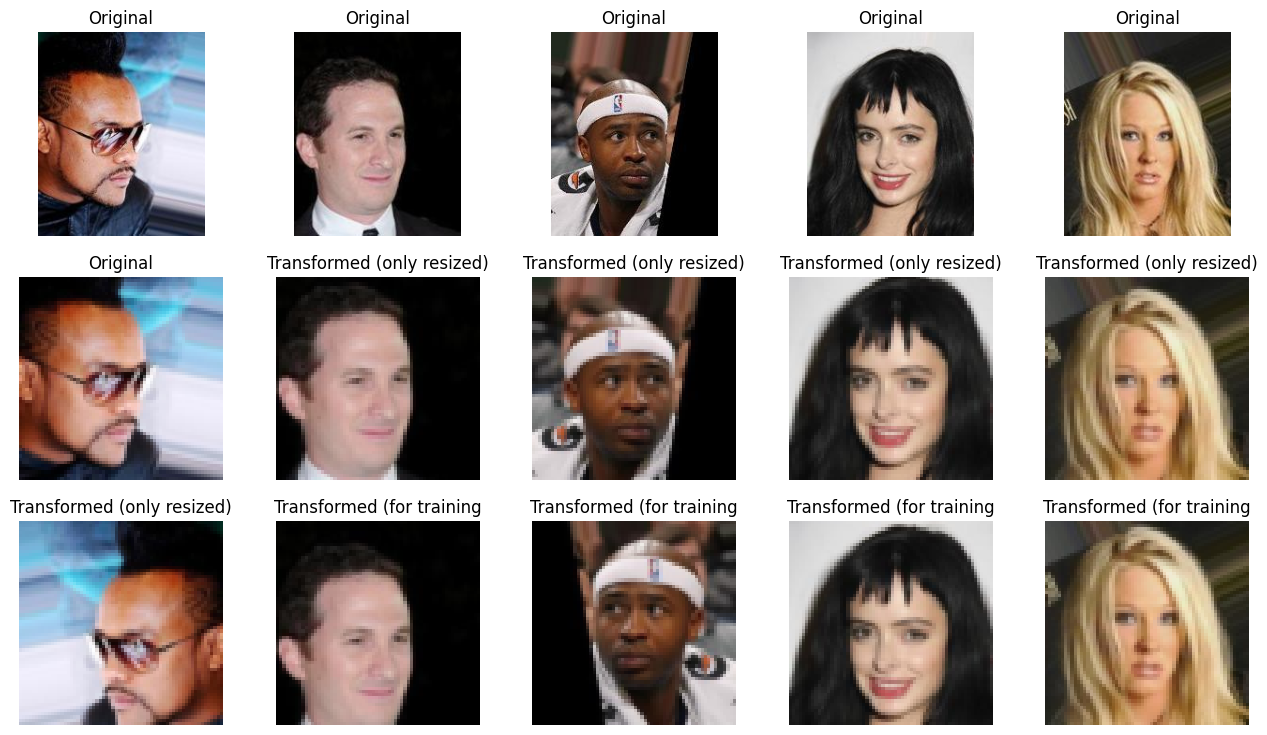

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get 5 random indices from the training set
indices = np.random.choice(len(merged_df), 5, replace=False)

# Load and transform images
original_images = []
transformed_images = []
transformed_images_training = []

to_tensor = transforms.ToTensor()
for idx in indices:
    img_name = merged_df.iloc[idx]['image_id']
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert('RGB')
    original_images.append(to_tensor(img))
    transformed_images.append(transform(img))
    transformed_images_training.append(transform_train(img))

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16, 9))
ax = ax.flatten()
for i, img in enumerate(original_images + transformed_images + transformed_images_training):
    ax[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax[i].axis('off')
    ax[i].set_title('Original' if i <= 5 else 'Transformed (only resized)' if i <= 10 else 'Transformed (for training')

Now we configure the class for the later data processing during the CNN training.

In [15]:
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]  # Get the image filename
        img_path = os.path.join(self.img_dir, img_name)  # Construct full image path
        image = Image.open(img_path).convert('RGB')  # Open and ensure image is in RGB mode
        # Get the label (Smiling column)
        label = self.df.iloc[idx, 2]  # Index 2 corresponds to 'Smiling' column
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float)

We take only 32k samples from the training dataset, and 2k from the validation. Training the model with the whole dataset would be computationally highly expensive.

In [16]:
train_df = merged_df[merged_df['partition'] == 'train'].sample(n=32000)
valid_df = merged_df[merged_df['partition'] == 'valid'].sample(n=2000)
test_df = merged_df[merged_df['partition'] == 'test']

train_dataset = CelebADataset(train_df, img_dir, transform=transform_train)
valid_dataset = CelebADataset(valid_df, img_dir, transform=transform)
test_dataset = CelebADataset(test_df, img_dir, transform=transform)

print(f'Train set length: {len(train_dataset)}')
print(f'Valid set length: {len(valid_dataset)}')

Train set length: 32000
Valid set length: 2000


In [26]:
len(train_df[train_df['Smiling'] == 1]) / len(train_df)

0.48509375

The data is pretty much balanced.

We will use batches of 128 samples for the Mini-Batch Stochastic Gradient Descent.

In [17]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## Modelling and training the Convolutional Neural-Network

In [18]:
import torch.nn as nn

In [19]:
# current size: batch x 3(RGB) x 64 x 64
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2)) # reduces spatial dimensions by 2
model.add_module('dropout1', nn.Dropout(p=0.5))

# current size: batch x 32 x 32 x 32
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

# current size: batch x 64 x 16 x 16
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout3', nn.Dropout(p=0.5))

# current size: batch x 128 x 8 x 8
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
model.add_module('relu4', nn.ReLU())

In [20]:
# check shape of the output feature maps using a toy 4 batch
x = torch.ones((4, 3, 64, 64)) # 64x64 because of the resize done by the transform
model(x).shape

torch.Size([4, 256, 8, 8])

There are 256 feature maps (or channels) of size 8×8.  

In [21]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) # Global Avg-pooling
# current size: batch x 256 x 1 x 1
model.add_module('flatten', nn.Flatten())
# current size: batch x 256

In [22]:
model(x).shape

torch.Size([4, 256])

Finally, we add a fully connected layer to a simple output unit. This let us use sigmoid activation.

In [23]:
model.add_module('fc', nn.Linear(in_features=256, out_features=1))
model.add_module('sigmoid', nn.Sigmoid())
# final size: batch x 1

In [24]:
model(x).shape

torch.Size([4, 1])

#### Model architecture description
Thus, the CNN model consists of multiple convolutional layers for feature extraction, ReLU activations for non-linearity, and max-pooling for dimensionality reduction. Dropout layers are included to prevent overfitting. The output is globally pooled to a single value per feature map, flattened, and passed through a fully connected layer with a sigmoid activation to produce a binary classification probability.  
It looks like this:

In [236]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Training and results

In [25]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)[:, 0] # batch_size x 1 -> batch_size
            loss = loss_fn(pred, y_batch.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1}\n'
              f'Training accuracy: {accuracy_hist_train[epoch]:.4f}, Validation accuracy: {accuracy_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Now, we define a loss function and an optimizer. The loss function, as we are working with a binary classification with a single probabilistic output, we will use Binary Cross-Entropy Loss (we could've also put 2 final neurons and a Softmax layer for a Cross-Entropy Loss, but it is not necessary since 1 output is enough). And for the optimizer, Adam.

In [27]:
loss_fn = nn.BCELoss()
# loss_fn = nn.BCEWithLogitsLoss() # this one is to be used if the final sigmoid layer wasn't applied
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0025)

device = torch.device("cuda:0")
model = model.to(device)

In [28]:
torch.manual_seed(0)
epochs = 35
hist = train(model, epochs, train_loader, valid_loader)

Epoch 1
Training accuracy: 0.5193, Validation accuracy: 0.5545
Epoch 2
Training accuracy: 0.5483, Validation accuracy: 0.5255
Epoch 3
Training accuracy: 0.5823, Validation accuracy: 0.6440
Epoch 4
Training accuracy: 0.6334, Validation accuracy: 0.6655
Epoch 5
Training accuracy: 0.6536, Validation accuracy: 0.6715
Epoch 6
Training accuracy: 0.6638, Validation accuracy: 0.6695
Epoch 7
Training accuracy: 0.6718, Validation accuracy: 0.6830
Epoch 8
Training accuracy: 0.6832, Validation accuracy: 0.7295
Epoch 9
Training accuracy: 0.7024, Validation accuracy: 0.7645
Epoch 10
Training accuracy: 0.7447, Validation accuracy: 0.7780
Epoch 11
Training accuracy: 0.7883, Validation accuracy: 0.8510
Epoch 12
Training accuracy: 0.8145, Validation accuracy: 0.8730
Epoch 13
Training accuracy: 0.8320, Validation accuracy: 0.8730
Epoch 14
Training accuracy: 0.8391, Validation accuracy: 0.8755
Epoch 15
Training accuracy: 0.8468, Validation accuracy: 0.8870
Epoch 16
Training accuracy: 0.8495, Validation ac

The final accuracies show that the model maintains high performance on both training and validation datasets. The consistent validation accuracy, always being a little bit higher than the training accuracy, indicates that the model is robust and generalizes well to new, unseen data. This suggests the model effectively adapts and performs reliably across different data.  
We save the model's state:

In [29]:
torch.save(model.state_dict(), 'model_CelebA_smile.pth')

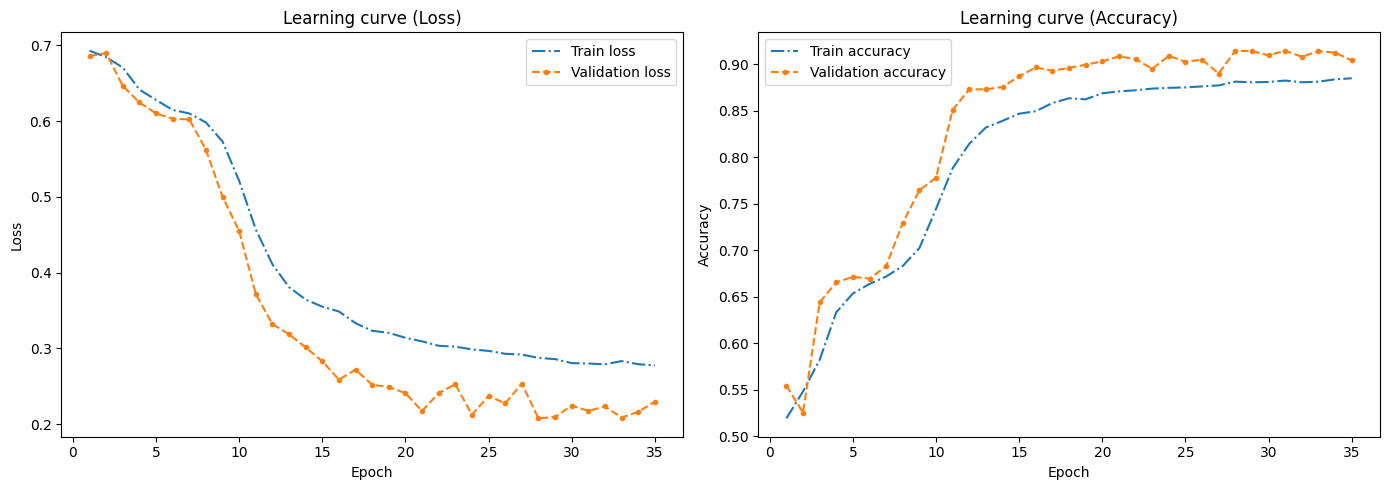

In [32]:
x_arr = np.arange(len(hist[0])) + 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(x_arr, hist[0], '-.', label='Train loss')
ax[0].plot(x_arr, hist[1], '--.', label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(x_arr, hist[2], '-.', label='Train accuracy')
ax[1].plot(x_arr, hist[3], '--.', label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

ax[0].set_title('Learning curve (Loss)')
ax[1].set_title('Learning curve (Accuracy)')

plt.tight_layout()

#### Test accuracy

In [33]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_loader.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.9012


#### Displaying some results on images

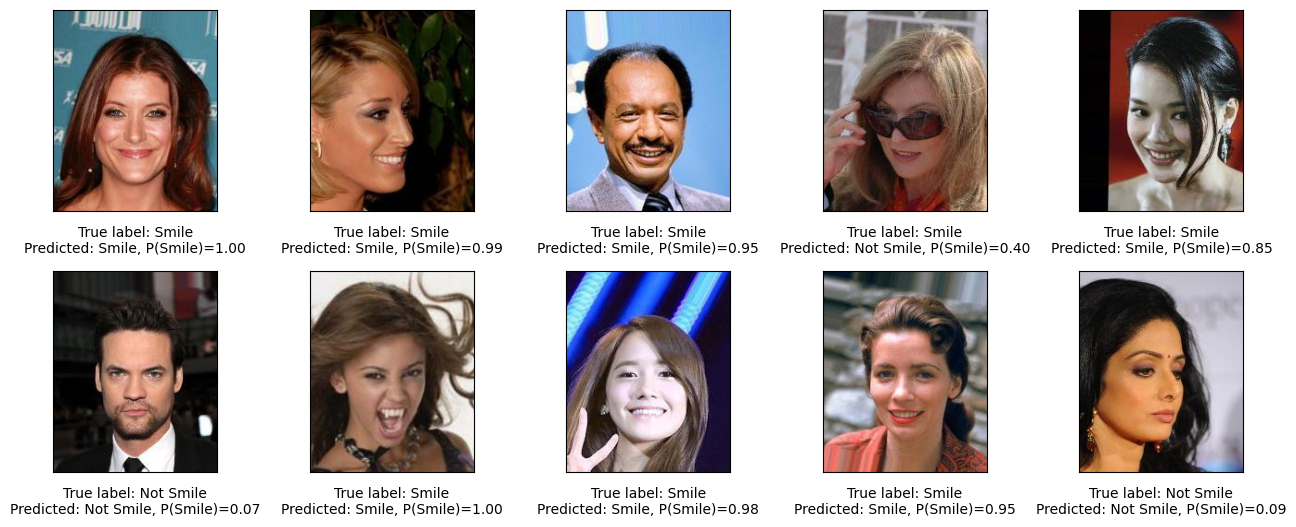

In [40]:
# Display original images from the test set corresponding to the final batch
fig = plt.figure(figsize=(16, 6))
num_images = min(len(x_batch), 20)

pred = model(x_batch)[:, 0]

# Iterate through the images in the current batch
for j in range(10, num_images):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])

    img_name = test_df.iloc[len(test_loader.dataset) - len(x_batch) + j]['image_id']
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert('RGB')
    ax.imshow(img)

    label = 'Smile' if y_batch[j].cpu().item() == 1 else 'Not Smile'
    ax.text(0.5, -0.15, 
        f'True label: {label:s}\nPredicted: {'Smile' if pred[j].cpu().item() >= 0.5 else 'Not Smile'}, '
        f'P(Smile)={pred[j].cpu().item():.2f}', 
        size=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes
    )

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()
